## Week 3 Class activities
This notebook is a starting point for the exercises and activities that we'll do in class.

Before you attempt any of these activities, make sure to watch the video lectures for this week.

### Joining tables
Let's look at the spatial distribution of vaccine hesitancy, early in the pandemic.

The CDC has a dataset at the county level, [available via Socrata](https://data.cdc.gov/Vaccinations/Vaccine-Hesitancy-for-COVID-19-County-and-local-es/q9mh-h2tw).


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Import the vaccine hesitancy dataset into a dataframe. Call it <strong>hesitancy</strong>.
</div>

*Hint*: Use the same approach as for the Seattle permits (class 2) or the Los Angeles housing (lecture 5). Just use a different URL.

*Hint*: Add the `limit` keyword at the end of the URL to get more than 1000 rows. [See the example here](https://github.com/socrata/discuss/issues/145). There are 3,142 rows, according to the dataset's webpage, so you will be safe if you specify a limit of (say) 5000 rows.

In [48]:
# your code here
hesitancy = 9999

In [49]:
# get the permit data from the API
import json
import requests
import pandas as pd


url = 'https://data.cdc.gov/resource/q9mh-h2tw.json?$limit=5000' # copied and pasted from the webpage
r = requests.get(url)
hesitancy = pd.DataFrame(json.loads(r.text))

Before we do any joins, let's look at some state-level summary statistics.

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Create a dataframe with the means of estimated_hesitant and the vaccination rate.
</div>

*Hints*:
- It might make more sense to weight each county by population, but let's not worry about that here.
- The `percent_adults_fully` columm gives the vaccination rate (as of June 2021)
- Use `groupby`!
- Before you do any operations, you might need to convert the data type of the column. I recommend creating a new column, e.g. `df['newcol'] = df.oldcol.astype(float)`

In [50]:
# your code here

In [52]:
hesitancy['hesitant'] = hesitancy.estimated_hesitant.astype(float)
hesitancy['vacc'] = hesitancy.percent_adults_fully.astype(float)
statelevel = hesitancy.groupby('state')[['hesitant','vacc']].mean()
statelevel.head()

,hesitant,vacc
state,,
ALABAMA,0.173507,0.320851
ALASKA,0.217386,0.582296
ARIZONA,0.159240,0.504733
ARKANSAS,0.212123,0.338800
CALIFORNIA,0.072274,0.506820


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Create a scatter plot of hesitancy vs vaccination rates.
</div>

In [53]:
# your code here

<AxesSubplot:xlabel='hesitant', ylabel='vacc'>

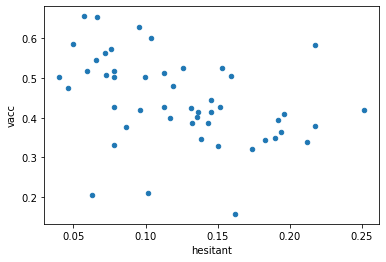

In [54]:
statelevel.plot.scatter(x='hesitant', y='vacc')

## Joining
Now let's do a join.
It looks like the county boundaries are in our original dataframe, but in a weird format. We could try and parse them. But instead, let's get the county boundaries and total population using `cenpy`. 

We'll just do one state, in order to reduce the sizes of the files for this exercise.

<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Get a geodataframe of the county boundaries and population totals for a state of your choice, using cenpy.
</div>

*Hints*: 
* The `from_state`, rather than `from_county` will be helpful. See the [docs](http://cenpy-devs.github.io/cenpy/generated/cenpy.products.ACS.from_state.html). 
* You'll need to specify the state (e.g. "California") and the level (use "county").
* A small state will download faster!
* The population variable is B01001_001E

In [16]:
import cenpy
acs = cenpy.products.ACS()
censusDf = 999 # replace with your code

censusDf.head()

In [56]:
import cenpy
acs = cenpy.products.ACS()
censusDf = acs.from_state("New Mexico", variables='B01001_001E', level="county") 
censusDf.head()

/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/opt/anaconda3/envs/uds/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.

,GEOID,geometry,B01001_001E,NAME,state,county
0,35013,"POLYGON ((-11869930.730 3762015.110, -11869934...",213849.0,"Doña Ana County, New Mexico",35,013
1,35028,"POLYGON ((-11822761.100 4277164.290, -11822508...",18031.0,"Los Alamos County, New Mexico",35,028
2,35053,"POLYGON ((-11883283.280 3958587.250, -11883288...",17098.0,"Socorro County, New Mexico",35,053
3,35007,"POLYGON ((-11578167.690 4379008.180, -11578174...",12522.0,"Colfax County, New Mexico",35,007
4,35025,"POLYGON ((-11473112.710 3807319.780, -11473110...",69505.0,"Lea County, New Mexico",35,025


You should have a `GEOID` column in your `censusDf`, as well as a geometry column.


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Join the covid dataframe to your census dataframe.</div>

*Hints:*:
* Look at which column gives the county FIPS code in each dataframe.
* Do the data types match? Anything else you need to clean up before joining?
* It might be helpful to do a left join from the census dataframe. That means that you will automatically drop the data for counties in other states.

In [57]:
# your code here

In [58]:
censusDf.set_index('GEOID', inplace=True)
hesitancy['GEOID'] = hesitancy.fips_code.astype(str).str.zfill(5)
hesitancy.set_index('GEOID', inplace=True)

joinedDf = censusDf.drop(columns='state').join(hesitancy)
joinedDf.head()

,geometry,B01001_001E,NAME,county,fips_code,county_name,state,estimated_hesitant,estimated_hesitant_or_unsure,estimated_strongly_hesitant,...,percent_non_hispanic_native,percent_non_hispanic_white,geographical_point,state_code,county_boundary,state_boundary,:@computed_region_hjsp_umg2,:@computed_region_skr5_azej,hesitant,vacc
GEOID,,,,,,,,,,,,,,,,,,,,,
35013,"POLYGON ((-11869930.730 3762015.110, -11869934...",213849.0,"Doña Ana County, New Mexico",013,35013,"DoÃƒÂ±a Ana County, New Mexico",NEW MEXICO,0.0692,0.1277,0.0365,...,0.0003,0.2724,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,NaN,NaN,11,616,0.0692,0.475
35028,"POLYGON ((-11822761.100 4277164.290, -11822508...",18031.0,"Los Alamos County, New Mexico",028,35028,"Los Alamos County, New Mexico",NEW MEXICO,0.061,0.1107,0.0314,...,0,0.7182,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0610,0.687
35053,"POLYGON ((-11883283.280 3958587.250, -11883288...",17098.0,"Socorro County, New Mexico",053,35053,"Socorro County, New Mexico",NEW MEXICO,0.0726,0.1295,0.0388,...,0,0.3419,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0726,0.509
35007,"POLYGON ((-11578167.690 4379008.180, -11578174...",12522.0,"Colfax County, New Mexico",007,35007,"Colfax County, New Mexico",NEW MEXICO,0.0805,0.1453,0.0436,...,0,0.4674,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0805,0.353
35025,"POLYGON ((-11473112.710 3807319.780, -11473110...",69505.0,"Lea County, New Mexico",025,35025,"Lea County, New Mexico",NEW MEXICO,0.0792,0.1355,0.0434,...,0.0002,0.3541,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0792,0.228


In [59]:
joinedDf.head()

,geometry,B01001_001E,NAME,county,fips_code,county_name,state,estimated_hesitant,estimated_hesitant_or_unsure,estimated_strongly_hesitant,...,percent_non_hispanic_native,percent_non_hispanic_white,geographical_point,state_code,county_boundary,state_boundary,:@computed_region_hjsp_umg2,:@computed_region_skr5_azej,hesitant,vacc
GEOID,,,,,,,,,,,,,,,,,,,,,
35013,"POLYGON ((-11869930.730 3762015.110, -11869934...",213849.0,"Doña Ana County, New Mexico",013,35013,"DoÃƒÂ±a Ana County, New Mexico",NEW MEXICO,0.0692,0.1277,0.0365,...,0.0003,0.2724,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,NaN,NaN,11,616,0.0692,0.475
35028,"POLYGON ((-11822761.100 4277164.290, -11822508...",18031.0,"Los Alamos County, New Mexico",028,35028,"Los Alamos County, New Mexico",NEW MEXICO,0.061,0.1107,0.0314,...,0,0.7182,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0610,0.687
35053,"POLYGON ((-11883283.280 3958587.250, -11883288...",17098.0,"Socorro County, New Mexico",053,35053,"Socorro County, New Mexico",NEW MEXICO,0.0726,0.1295,0.0388,...,0,0.3419,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0726,0.509
35007,"POLYGON ((-11578167.690 4379008.180, -11578174...",12522.0,"Colfax County, New Mexico",007,35007,"Colfax County, New Mexico",NEW MEXICO,0.0805,0.1453,0.0436,...,0,0.4674,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0805,0.353
35025,"POLYGON ((-11473112.710 3807319.780, -11473110...",69505.0,"Lea County, New Mexico",025,35025,"Lea County, New Mexico",NEW MEXICO,0.0792,0.1355,0.0434,...,0.0002,0.3541,"{'type': 'Point', 'coordinates': [-106.108388,...",NM,"{'type': 'MultiPolygon', 'coordinates': [[[[-1...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",11,616,0.0792,0.228


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Create some county-level maps and other simple analyses.
</div>

The [geopandas documentation](https://geopandas.org/en/stable/docs/user_guide/mapping.html) has some useful tips.

Hint: make sure your column is numeric before you plot it!

In [60]:
# your code here

<AxesSubplot:>

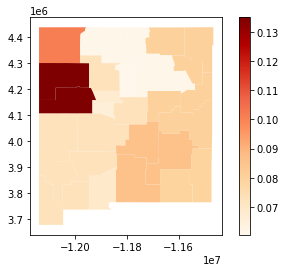

In [61]:
# super basic but a start

joinedDf['hesitant_numeric'] = joinedDf.estimated_hesitant.astype(float)
joinedDf.plot('hesitant_numeric',  cmap='OrRd', legend=True)

<div class="alert alert-block alert-info">
<h3>What you should have learned</h3>
<ul>
  <li>Gain more practice with the APIs</li>
  <li>Understand basic data cleaning operations, such as converting strings to numeric fields.</li>
  <li>Understand how to compute group-level means and other summary statistics.</li>
    <li>Understand how to join tables on a common column.</li>
</ul>
</div>